# Lab 3 - Query Expansion

In [8]:
import os
import chromadb
from helper_utils import word_wrap, project_embeddings
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
openai_api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddingFunction(api_key=openai_api_key, model_name="text-embedding-3-small")

chroma_collection = chromadb.PersistentClient('microsoft_annual_report_2022').create_collection(
    "microsoft_annual_report_2022", 
    embedding_function=embedding_function,
    get_or_create=True)
chroma_collection.count()

307

In [10]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [11]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/rares/proj/notebook/adv-retrieval-w-chroma/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 307/307 [00:06<00:00, 50.73it/s] 


## Expansion with generated answers

https://arxiv.org/abs/2305.03653

In [12]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [13]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past
fiscal year, there was no significant turnover in the executive team.
The core members of the executive team have remained stable, providing
continuity in leadership and strategy execution. This consistency in
leadership has contributed to the organization's continued success and
growth initiatives.


In [14]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

Management conducted an evaluation of the effectiveness of our internal
control over financial reporting based on the framework in Internal
Control – Integrated Framework (2013) issued by the Committee of
Sponsoring Organizations of the Treadway Commission. Based on this
evaluation, management concluded that the Company’s internal control
over financial reporting was effective as of June 30, 2022. There were
no changes in our internal control over financial reporting during the
quarter ended June 30, 2022 that have materially affected, or are
reasonably likely to materially affect, our internal control over
financial reporting. Deloitte & Touche LLP has audited our internal
control over financial reporting as of June 30, 2022; their report
follows

The Board of Directors, through its Audit Committee, consisting solely
of independent directors of the Company, meets periodically with
management, internal auditors, and our independent registered public
accounting firm to ensure that each 

In [15]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 216.25it/s]


(np.float64(-2.481528162956238),
 np.float64(6.624906897544861),
 np.float64(3.7107146739959718),
 np.float64(11.944174432754517))

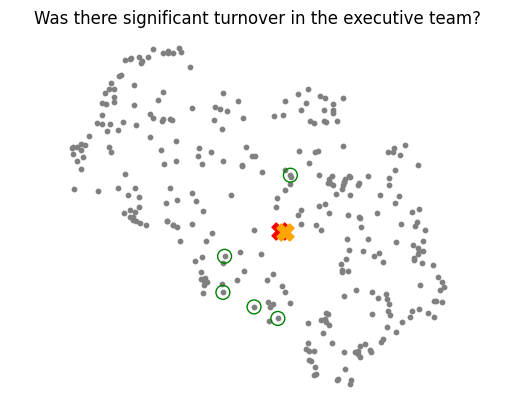

In [16]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries


In [17]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [18]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- What were the key drivers of revenue growth during the reporting period?
- How did changes in pricing or product mix impact revenue performance?
- Were there any significant acquisitions or divestitures that influenced revenue growth?
- Which geographic regions or customer segments experienced the highest revenue growth?
- Did the company introduce any new products or services that contributed to revenue increases?


In [19]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
Windows OEM revenue increased 11% driven by continued strength in the
commercial PC market, which has higher revenue per license. Windows
Commercial products and cloud services revenue increased 11% driven by
demand for Microsoft 365. 36 • Search and news advertising revenue
increased $2.3 billion or 25%. Search and news advertising revenue
excluding traffic acquisition costs increased 27% driven by higher
revenue per search and search volume. • Gaming revenue increased $860
million or 6% on a strong prior year comparable that benefited from
Xbox Series X|S launches and stay -at-home scenarios, driven by growth
in Xbox hardware and Xbox content and services. Xbox hardware revenue
increased 16% due to continued demand for Xbox Series X|S. Xbox content
and services revenue increased 3% driven by growth in Xbox Game Pass
subscriptions and first - party content, offset in part by a decline in
th

In [20]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 236.43it/s]


In [21]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:00<00:00, 267.24it/s]


(np.float64(-2.481528162956238),
 np.float64(6.624906897544861),
 np.float64(3.7107146739959718),
 np.float64(11.944174432754517))

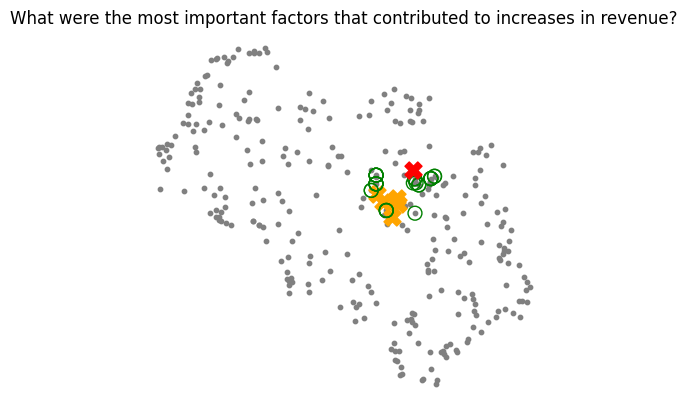

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')